In [1]:
from __future__ import division
import os
import sys
import copy
import numpy as np
from numpy import ma
import math as m
import pandas as pd
import matplotlib.patches as mpatches
import string
import cmasher as cmr

import pickle
from numpy import genfromtxt
from scipy.interpolate import griddata
from matplotlib import rc
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

import datetime
from matplotlib.dates import DayLocator, MonthLocator, HourLocator, AutoDateLocator, DateFormatter, drange
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from numpy import arange
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm
import matplotlib.mlab as mlab

import glob

In [2]:
# Font / Figure Size
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)
#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#rc('text', usetex=True)

pylab.rcParams['xtick.major.pad']='12'
pylab.rcParams['ytick.major.pad']='12'
pylab.rcParams['axes.titlepad'] = 35
pylab.rcParams['axes.labelpad'] = 15

In [3]:
# Custom Colors

darkblue = '#4e79a7'
orange = '#f28e2b'
red = '#e15759'
lightblue = '#76b7b2'
green = '#59a14f'
yellow = '#edc948'
purple = '#b07aa1'
pink = '#ff9da7'
brown = '#9c755f'
gray = '#bab0ac'

# Make Legend
solar = mpatches.Patch(color=yellow, label='Solar')
wind = mpatches.Patch(color='cornflowerblue', label='Wind')
batt = mpatches.Patch(color=purple, label='Li-ion')
rfb = mpatches.Patch(color=green, label='RFB')
caes = mpatches.Patch(color=lightblue, label='CAES')
psh = mpatches.Patch(color=darkblue, label='PSH')
thermal = mpatches.Patch(color=orange, label='Thermal')
gravitational = mpatches.Patch(color=red, label='Gravitational')
metal_air = mpatches.Patch(color=gray, label='Metal-Air')
pgp = mpatches.Patch(color=pink, label='PGP')

In [4]:
file_name = 'C:\\Users\\Anna\\Documents\\MEM-master\\Cost_Assumptions\\Summary_of_Storage_Tech_Costs.xlsx'
sheet1 = 'Total Overnight Costs' # 'tic'
sheet2 = 'RTEs' # 'rte'

toc = pd.read_excel(io=file_name, sheet_name=sheet1, skiprows=1, header=0)
rte = pd.read_excel(io=file_name, sheet_name=sheet2, skiprows=1, header=0)

In [5]:
from extract_data_sep_power import get_data_sep_power
from extract_data_one_power import get_data_one_power

In [6]:
def pie_chart(ax, index, tech_name, energy_midpoint, power_midpoint, RTE):
    theta = (RTE * 360 - 90)
    radius = 0.045
    ax.add_patch(mpatches.Circle((energy_midpoint, power_midpoint), radius, edgecolor=gray,
                                 facecolor='white', fill=True, lw=1, transform=ax.transAxes, clip_on=False,
                                zorder=100))
    ax.add_patch(mpatches.Wedge((energy_midpoint, power_midpoint), radius, -theta, 90, 
                                facecolor=storage_colors[index], fill=True, linewidth=None,
                               transform=ax.transAxes, clip_on=False, zorder=100))

In [7]:
Li_ion_PGP_X_dataframes = {}
Li_ion_X_dataframes = {}
PGP_X_dataframes = {}

def cost_conts(ax, path, x_labels, dataframes):
    dic = {}
    solar_cost = np.empty(len(x_labels))
    wind_cost = np.empty(len(x_labels))
    batt_cost = np.empty(len(x_labels))
    storage_x_cost = np.empty(len(x_labels))
    pgp_cost = np.empty(len(x_labels))
    
    for i, x_label in enumerate(x_labels):
        if x_label == 'CAES':
            dic[x_label] = get_data_sep_power(path + '/' + x_label, 2, 'fixed_cost', 3, 'fixed_cost', False)
            your_keys = ['system_cost', 
                         'battery_cap',
                         'third_tech_dur', 'to_third_tech_cap', 'third_tech_energy_cap', 'from_third_tech_cap',
                         'PGP_dur', 'to_PGP_cap', 'PGP_storage_cap', 'from_PGP_cap']
            data_you_want = {your_key: None if dic[x_label][your_key][0] is None
                         else round(dic[x_label][your_key][0], 3)
                         for your_key in your_keys}
            dataframes[x_label] = pd.DataFrame.from_dict(data_you_want, orient='index', columns=[x_label])
        else:
            dic[x_label] = get_data_one_power(path + '/' + x_label, 2, 'fixed_cost', 3, 'fixed_cost', False)
            your_keys = ['system_cost', 
                         'battery_cap',
                         'third_tech_dur', 'third_tech_power_cap', 'third_tech_energy_cap',
                         'PGP_dur', 'to_PGP_cap', 'PGP_storage_cap', 'from_PGP_cap']
            data_you_want = {your_key: None if dic[x_label][your_key][0] is None
                         else round(dic[x_label][your_key][0], 3)
                         for your_key in your_keys}
            temp_df = pd.DataFrame.from_dict(data_you_want, orient='index', columns=[x_label])
            head = temp_df[:5]
            tail = temp_df[5:]
            inserted = pd.DataFrame([[np.nan] * len(temp_df.columns)], columns=temp_df.columns)
            dataframes[x_label] = head.append(inserted, ignore_index=True)
            dataframes[x_label] = dataframes[x_label].append(tail, ignore_index=True)
        
        solar_cost[i] = dic[x_label]['solar_cost'][0]
        wind_cost[i] = dic[x_label]['wind_cost'][0]
        pgp_cost[i] = dic[x_label]['pgp_cost'][0]
        storage_x_cost[i] = dic[x_label]['third_tech_cost'][0]
        batt_cost[i] = dic[x_label]['batt_cost'][0]
    
    w=0.8
    ax.bar(x_labels, solar_cost, label='Solar', color=yellow, width=w)
    ax.bar(x_labels, wind_cost, bottom=solar_cost, label='Wind', color='cornflowerblue', width=w)
    ax.bar(x_labels, pgp_cost, bottom=solar_cost+wind_cost, label='PGP', color=pink, width=w)
    ax.bar(x_labels, storage_x_cost, bottom=solar_cost+wind_cost+pgp_cost, label='Storage X', color=storage_x_colors, width=w)
    ax.bar(x_labels, batt_cost, bottom=solar_cost+wind_cost+pgp_cost+storage_x_cost, label='Li-ion', color=purple, width=w)
    
    plt.xticks(rotation=90)   

C:\Users\Anna\AppData\Local\Temp\ipykernel_20504\1317980989.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Li-ion  +  PGP', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])
C:\Users\Anna\AppData\Local\Temp\ipykernel_20504\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_20504\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = dataframes[x_label].append(tail, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_20504\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

Text(-0.25, 1.25, 'b) Li-ion + PGP + Storage X\n')

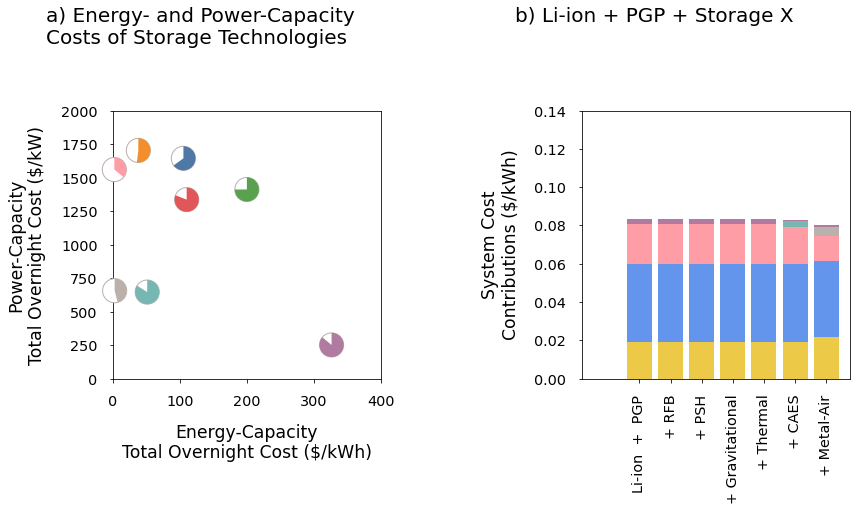

In [8]:
directory = 'C:\\Users\\Anna\\Documents\\MEM-master\\Output_Data\\Mid_Duration\\Three_Techs_Li-ion_PGP_X'

# Set up techs

without_x = 'Li-ion_PGP'

storage_names = ['Li-ion', 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air', 'PGP']
storage_colors= [purple, green, darkblue, red, orange, lightblue, gray, pink]

storage_x_names = [without_x, 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air',]
storage_x_colors = ['white', green, darkblue, red, orange, lightblue, gray,]

# Plot Figure

num_rows = 1
fig_w = 12
fig_h = 6
fig = plt.subplots(nrows=1,ncols=2, figsize=(fig_w,fig_h))


#####################################################################
#         Total Overnight Costs and Round Trip Efficiencies         #
#####################################################################

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

#ax1.set_title('a) Total Overnight Costs\n           of Storage Technologies')
ax1.set_xlabel('Energy-Capacity\nTotal Overnight Cost ($/kWh)')
ax1.set_ylabel('Power-Capacity\nTotal Overnight Cost ($/kW)')

min_energy_toc = 0
max_energy_toc = 400

min_power_toc = 0
max_power_toc = 2000

ax1.set_xlim(min_energy_toc, max_energy_toc)
ax1.set_ylim(min_power_toc, max_power_toc)

for i, tech_name in enumerate(storage_names):
    tech_toc = toc.iloc[i]
    tech_rte = rte.iloc[i]
    energy_midpoint = tech_toc['Energy Base Case'] - min_energy_toc
    power_midpoint = tech_toc['Power Base Case']
    
    pie_chart(ax1, i, tech_name, energy_midpoint/(max_energy_toc-min_energy_toc), power_midpoint/max_power_toc, tech_rte['RTE Midpoint'])

#####################################################################
#         Cost Contributions of Different Storage X Techs           #
#####################################################################

ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

ax2.set_ylabel('System Cost\nContributions ($/kWh)')
ax2.set_xticklabels(['Li-ion  +  PGP', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])

cost_conts(ax2, directory, storage_x_names, Li_ion_PGP_X_dataframes)
  
#####################################################################

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.75, hspace=0.25)

ax2.set_xlim(-1.85, 6.75)
ymax = 0.14
ax2.set_ylim(0, ymax)

ax1.text(-0.25, 1.25, 'a) Energy- and Power-Capacity\nCosts of Storage Technologies', transform=ax1.transAxes, fontsize=20)
ax2.text(-0.25, 1.25, 'b) Li-ion + PGP + Storage X\n', transform=ax2.transAxes, fontsize=20)

C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = dataframes[x_label].append(tail, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

(0.074, 0.085)

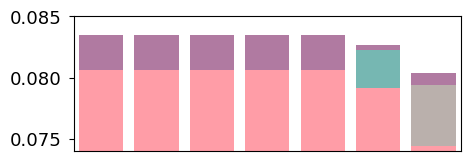

In [41]:
fig = plt.figure(figsize=(5, 1.75))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
cost_conts(ax, Li_ion_PGP_X_directory, Li_ion_PGP_X_techs, Li_ion_PGP_X_dataframes)
ax.tick_params(axis='both', which='major', labelsize=13, pad=5)
ax.set_xticks([])
ax.set_xlim(-0.5, 6.5)
ax.set_ylim(0.074, 0.085)

C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\1886496610.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Li-ion', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = dataframes[x_label].append(tail, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe

Text(-0.25, 1.25, 'b) PGP + Storage X')

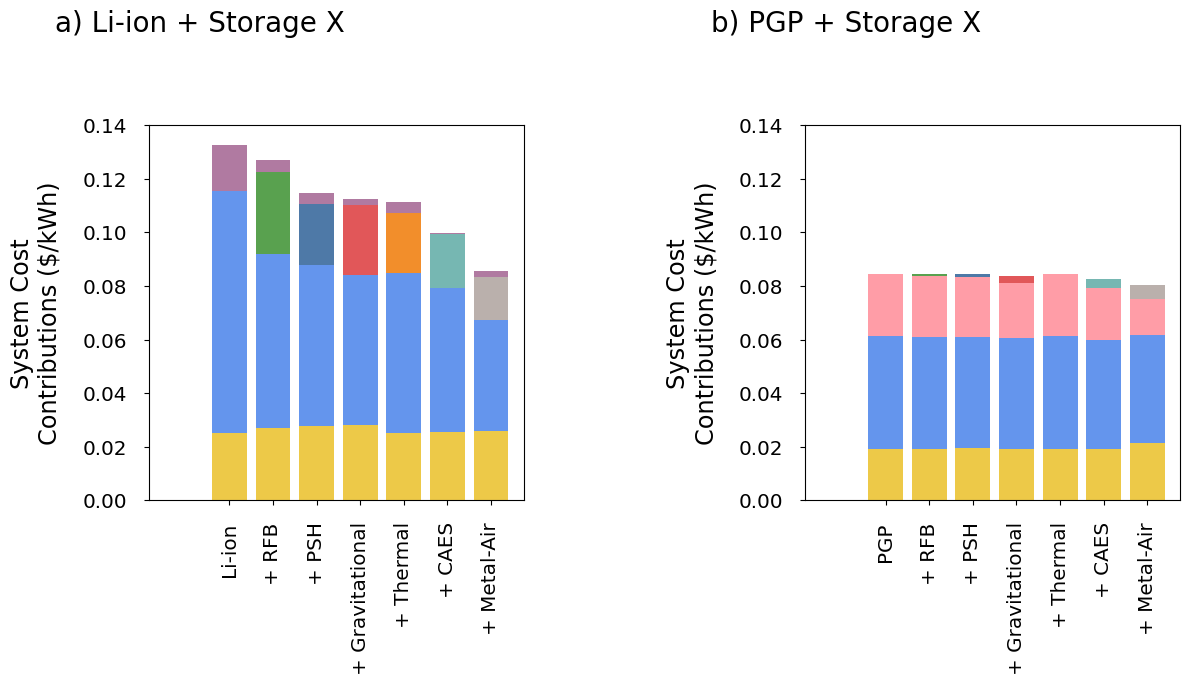

In [48]:
Li_ion_PGP_X_directory = 'C:\\Users\\Anna\\Documents\\MEM-master\\Output_Data\\Mid_Duration\\Three_Techs_Li-ion_PGP_X'
PGP_X_directory = 'C:\\Users\\Anna\\Documents\\MEM-master\\Output_Data\\Mid_Duration\\Two_Techs_PGP_X'
Li_ion_X_directory = 'C:\\Users\\Anna\\Documents\\MEM-master\\Output_Data\\Mid_Duration\\Two_Techs_Li-ion_X'

# Set up techs

storage_names = ['Li-ion', 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air', 'PGP']
storage_colors= [purple, green, darkblue, red, orange, lightblue, gray, pink]

Li_ion_PGP_X_techs = ['Li-ion_PGP', 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air']
PGP_X_techs = ['PGP', 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air']
Li_ion_X_techs = ['Li-ion', 'RFB', 'PSH', 'Gravitational', 'Thermal', 'CAES', 'Metal-Air']

storage_x_colors = ['white', green, darkblue, red, orange, lightblue, gray]

# Plot Figure

num_rows = 1
fig_w = 12
fig_h = 6
fig = plt.subplots(nrows=1,ncols=2, figsize=(fig_w,fig_h))

########################################################################################
#         Li-ion + PGP + X : Cost Contributions of Different Storage X Techs           #
########################################################################################

#ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
#ax1.set_title('a) Li-ion + PGP + Storage X')

#ax1.set_ylabel('System Cost\nContributions ($/kWh)')
#ax1.set_xticklabels(['Li-ion + PGP', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])

#cost_conts(ax1, Li_ion_PGP_X_directory, Li_ion_PGP_X_techs, Li_ion_PGP_X_dataframes)

# Zoom in

#ax1ins = ax1.inset_axes([0.25, 0.5, 0.25, 1])

#cost_conts(ax1ins, Li_ion_PGP_X_directory, Li_ion_PGP_X_techs)
#ax1ins.set_ylim(0.0735, 0.085)

###############################################################################
#         PGP + X : Cost Contributions of Different Storage X Techs           #
###############################################################################

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

ax1.set_ylabel('System Cost\nContributions ($/kWh)')
ax1.set_xticklabels(['Li-ion', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])

cost_conts(ax1, Li_ion_X_directory, Li_ion_X_techs, Li_ion_X_dataframes)

####################################################################################
#         Li-ion + X: Cost Contributions of Different Storage X Techs           #
####################################################################################

ax2= plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1, 
                      adjustable='box', sharey=ax2)

ax2.set_ylabel('System Cost\nContributions ($/kWh)')
ax2.set_xticklabels(['PGP', '+ RFB', '+ PSH', '+ Gravitational', '+ Thermal', '+ CAES', '+ Metal-Air'])

cost_conts(ax2, PGP_X_directory, PGP_X_techs, PGP_X_dataframes)
  
#####################################################################

# Set x and y lims

ax1.set_xlim(-1.85, 6.75)
ax2.set_xlim(-1.85, 6.75)

ymax = 0.14
ax1.set_ylim(0, ymax)
ax2.set_ylim(0, ymax)

#####################################################################

ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.75, hspace=0.25)

ax1.text(-0.25, 1.25, 'a) Li-ion + Storage X', transform=ax1.transAxes, fontsize=20)
ax2.text(-0.25, 1.25, 'b) PGP + Storage X', transform=ax2.transAxes, fontsize=20)

C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = dataframes[x_label].append(tail, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframes[x_label] = head.append(inserted, ignore_index=True)
C:\Users\Anna\AppData\Local\Temp\ipykernel_30524\797170485.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

(0.074, 0.085)

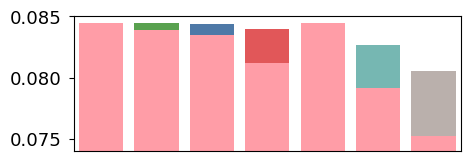

In [45]:
fig = plt.figure(figsize=(5, 1.75))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
cost_conts(ax, PGP_X_directory, PGP_X_techs, PGP_X_dataframes)
ax.tick_params(axis='both', which='major', labelsize=13, pad=5)
ax.set_xticks([])
ax.set_xlim(-0.5, 6.5)
ax.set_ylim(0.074, 0.085)

In [135]:
df1 = dataframes['PGP']
df2 = dataframes['RFB']
df3 = dataframes['PSH']
df4 = dataframes['Gravitational']
df5 = dataframes['Thermal']
df6 = dataframes['CAES']
df7 = dataframes['Metal-Air']
pd.concat([df1.set_index(df6.index), df2.set_index(df6.index), 
           df3.set_index(df6.index), df4.set_index(df6.index),
           df5.set_index(df6.index), df6.set_index(df6.index),
           df7.set_index(df6.index)], axis=1)

,PGP,RFB,PSH,Gravitational,Thermal,CAES,Metal-Air
system_cost,0.084,0.084,0.084,0.084,0.084,0.083,0.081
battery_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN
third_tech_dur,0.000,1.807,4.424,3.567,0.000,27.766,85.164
to_third_tech_cap,NaN,0.029,0.043,0.163,0.000,0.095,0.487
third_tech_energy_cap,NaN,0.052,0.191,0.583,0.000,2.641,41.479
from_third_tech_cap,NaN,NaN,NaN,NaN,NaN,0.250,NaN
PGP_dur,418.765,430.835,432.587,508.812,418.765,583.293,792.791
to_PGP_cap,0.198,0.195,0.189,0.181,0.198,0.165,0.093
PGP_storage_cap,368.036,366.558,362.759,367.673,368.036,375.212,324.302
from_PGP_cap,0.879,0.851,0.839,0.723,0.879,0.643,0.409
